<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/BT_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-9_7i91lp/base-rbt_cb45f8acc23d477fa984834c7327d553
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-9_7i91lp/base-rbt_cb45f8acc23d477fa984834c7327d553
     |████████████████████████████████| 551 kB 27.4 MB/s 
     |████████████████████████████████| 41 kB 563 kB/s 
     |████████████████████████████████| 548 kB 84.6 MB/s 
     |████████████████████████████████| 163 kB 93.0 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=20147 sha256=51e7c846a5ffce5d36c6de87fdbaec349a2c9a72593558438e0b493f6dd6270d
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0gc6rcp/wheels/7c/4c/c6/65c6f336ed53f534c05ca6736718e1e18f359920a1ef911674
Successfully built base-rbt


In [2]:
#See commit  for state of system
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [3]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

In [4]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

#Make models directory
#import os
#os.makedirs('/content/drive/MyDrive/models')

Mounted at /content/drive


In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt(pred,seed=self.seed,I=self.I,lmb=self.lmb)

**Ok now let's do an end to end CIFAR10 example. Let's comment a little more on the API as we go - this will be helpful when considering how to add functionality to (in particular) base_model**

Here are the steps at a high level:
- Define hps (e.g. batch size, projector dimension etc). Note that if the model changes then there may be different hps
- Get the data (train, tune, test) -> dls,dls_val, dls_test
- Patch in loss function definition
- Setup/define augmentations, encoder, model, learner
- Train BT/RBT (i.e. fit the learner
- Train linear classifier and record performance

Step 1): We need the data, and to set all the hps. 

In [15]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=42 #Will have to try with different random seeds. Two times is probably enough 
n_in=3
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=32
ps=500 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=128 #for training linear head
bs_test=500 #for evaluating linear head. Divides 10000
ts_val=bs_val*4 #so 512, ~ 1% of 50000
ts=50000-ts_val #

n_epoch=1000 #epochs for BT 
numfit = 400 #epochs for linear classifer


In [16]:
#data: dls, dls_val, dls_test
#get the data: Need dls, dls_val, dls_test
path = untar_data(URLs.CIFAR)
fnames = get_image_files(path / "train")
fnames.sort()
#shuffle data (in reproducible way)
seed_everything(seed=seed)
fnames = fnames.shuffle()

#fnames for train, eval and test
fnames_train = fnames[0:ts]
fnames_val = fnames[ts:ts+ts_val]

fnames_test = get_image_files(path / "test")
#fnames_test = fnames[ts+ts_val:ts+ts_val+ts_test]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]
labels_train = labels[0:ts]
labels_val = labels[ts:ts+ts_val]
labels_test = [label_func(fname) for fname in fnames_test]

#Used for training encoder i.e. BT
dls = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)
#Used for training linear classifier
dls_val = ImageDataLoaders.from_lists(path, fnames_val, labels_val,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)

#Used for evaluating linear classifier
dls_test = ImageDataLoaders.from_lists(path, fnames_test, labels_test,bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,seed=seed)


test_eq(len(dls.train_ds),49488)
test_eq(len(dls_val.train_ds),512)

set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

Test the random seed:

In [17]:
test_eq(fnames_train[0].name,'942_automobile.png')
test_eq(fnames_val[22].name,'4690_truck.png')

Patch in definition of loss function (BT for now):

In [18]:
#Using BT
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred, self.I,self.lmb)

In [ ]:
# def lf_rbt(pred,seed,I,lmb):
    
#     bs,nf = pred.size(0)//2,pred.size(1)

#     #All standard, from BT
#     z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
#     z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#     z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
#     C = (z1norm.T @ z2norm) / bs 
#     cdiff = (C - I)**2

#     #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
#     #where the max is over f and g. Please see base_lf for details
#     CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=5,indep=False)
#     cdiff_2 = CdiffSup(z1norm,z2norm) #same shape as cdiff

#     #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
#     CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=2,indep=True)
#     cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

#     cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

#     rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

#     loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
#     torch.cuda.empty_cache()
#     return loss

In [ ]:
# # #Using RBT
#@patch
# def lf(self:BarlowTwins, pred,*yb): return lf_rbt(pred,seed=self.seed,I=self.I,lmb=self.lmb)

We also patch `before_epoch` so that we are training linear classifier:
    

Setup for linear evaluation:

In [19]:
aug_pipelines_val=[get_linear_batch_augs(size=size,stats=cifar_stats,resize_scale=(0.3, 1.0))]
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                    dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                    stats=cifar_stats,
                    aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                    encoder=None#encoder
                                )

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


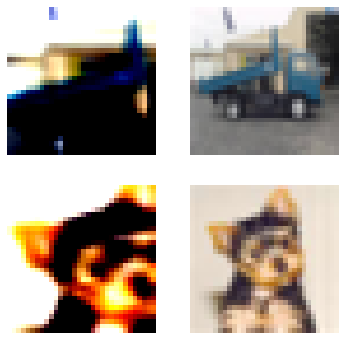

In [11]:
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Patch linear evaluation into `after_epoch:`

In [20]:
@patch
def after_epoch(self:BarlowTwins):

    if (self.epoch+1)%250 !=0: #Every 250th epoch train linear evaluation
        return 

    #Put in eval mode and turn gradients off
    self.learn.eval()
    grad_on(self.learn.model,on=False)
    
    #Test in eval mode
    test_eq(self.learn.model.training,False)
    #Test gradients off
    test_grad_off(self.learn.model)

    ##########
    main_linear_eval.encoder = self.learn.model.encoder #Update the encoder 
    main_linear_eval.model = LinearModel(encoder=main_linear_eval.encoder,indim=indim) #update the model (frozen encoder + head)
    acc = main_linear_eval() #train linear head on frozen encoder and get accuracy on test set
    self.acc_dict[self.epoch]=acc #update the acc_dict
    print(f'After epoch {self.epoch} acc of linear eval is {acc}')
    ##########
    
    #Put in train mode and turn gradients back on
    self.learn.train()
    grad_on(self.learn.model,on=True)

    #Test training mode on
    test_eq(self.learn.model.training,True)
    #Test gradients on
    test_grad_on(self.learn.model)

    if self.epoch+1 == self.learn.n_epoch:
        self.learn.save ('delthis', with_opt=True, pickle_protocol=2)
    

Define encoder and model; Define augmentation pipelines; Define learner.  

In [21]:
fastai_encoder = create_fastai_encoder(xresnet34(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)


aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.2, jitter_p=0.8, blur_p=1.0,sol_p=0.0,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                                                 bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                 resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.025, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
                                                 bw_p=0.2, flip_p=0.5,rotate_p=0.1,noise_p=0.1, jitter_p=0.8, blur_p=0.1,sol_p=0.2,
                                                 stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                 )

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#If we are using a different `callback` to `BarlowTwins` then we can simply replace `BarlowTwins` with 
#e.g. `BarlowTriplets`. We can define in base_model and just import with no issues. 
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#Set path of learn correctly
learn.path = Path('/content/drive/MyDrive/')

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 5, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 5, 's1': None, 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

        

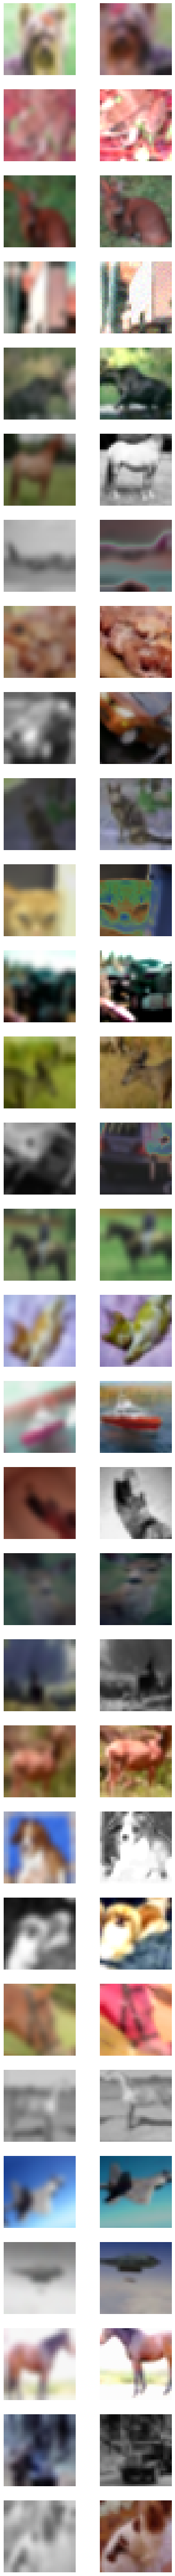

In [14]:
show_bt_batch(dls=dls,n_in=n_in,aug=aug_pipelines,n=30,print_augs=True)

Step 4): Fit the learner:

In [25]:
#This will also perform linear evaluation every x epochs (see `before_batch`) above 
learn.fit(n_epoch)
learn.barlow_twins.acc_dict

epoch,train_loss,valid_loss,time
0,96.986267,None,00:52
1,84.030258,None,00:47
2,67.914612,None,00:46
3,66.542038,None,00:46
4,64.728638,None,00:46
5,60.456444,None,00:46
6,57.902191,None,00:46
7,55.083687,None,00:46
8,55.024658,None,00:46
9,52.685658,None,00:46


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.207883,None,00:01
1,1.965662,None,00:01
2,1.786848,None,00:01
3,1.655522,None,00:01
4,1.547136,None,00:01
5,1.462570,None,00:01
6,1.398312,None,00:01
7,1.350391,None,00:01
8,1.303780,None,00:01
9,1.265862,None,00:01


After epoch 249 acc of linear eval is 0.5755000114440918


epoch,train_loss,valid_loss,time
0,96.986267,None,00:52
1,84.030258,None,00:47
2,67.914612,None,00:46
3,66.542038,None,00:46
4,64.728638,None,00:46
5,60.456444,None,00:46
6,57.902191,None,00:46
7,55.083687,None,00:46
8,55.024658,None,00:46
9,52.685658,None,00:46


epoch,train_loss,valid_loss,time
0,2.298780,None,00:02
1,2.098492,None,00:02
2,1.933853,None,00:02
3,1.816183,None,00:02
4,1.704376,None,00:02
5,1.603079,None,00:02
6,1.533993,None,00:02
7,1.473865,None,00:02
8,1.420881,None,00:02
9,1.363836,None,00:02


After epoch 499 acc of linear eval is 0.595300018787384


epoch,train_loss,valid_loss,time
0,2.307737,None,00:02
1,2.134776,None,00:02
2,1.980537,None,00:02
3,1.843363,None,00:02
4,1.725750,None,00:02
5,1.644006,None,00:02
6,1.561878,None,00:02
7,1.491514,None,00:02
8,1.437344,None,00:02
9,1.376116,None,00:02


After epoch 749 acc of linear eval is 0.5942000150680542


KeyboardInterrupt: ignored

In [28]:
learn.barlow_twins.acc_dict

{249: 0.5755000114440918, 499: 0.595300018787384, 749: 0.5942000150680542}

In [ ]:
 #load learner, at least within session... `(but you can view it in drive)
 #learn = learn.load (file=Path('/content/drive/MyDrive/models/delthis'), device=device, with_opt=True, strict=True)